# Energy System Model

Load python libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os
import datetime
%matplotlib inline

Load 3YP specific libraries

In [3]:
os.chdir("/Users/scotwheeler/Documents/repos/leo_3yp_2020/")  # set working directory to main folder, one folder above where this notebook is stored


# import modules from OxEMF package
from OxEMF import Assets as AS
from OxEMF import EnergySystem as ES      
import OxEMF.Market as MK

os.chdir("OxEMF/")

Set parameters common to energy system

In [4]:
dt = 30/60 #1 minute time intervals
T = int((24*365)/dt) #Number of intervals

Setup the assets

In [5]:
dispatchable = []
non_dispatchable = []
all_assets = []
pv_sites = []

# PV source
# 3 PV installations
pv_capacities = [2,5,15]  # kW
for pv_cap in pv_capacities:
    pv_site = AS.pvAsset(pv_cap)
    pv_sites.append(pv_site)
    non_dispatchable.append(pv_site)

# Load
# 1 group of 10 households
nHouses = 10
load_site1 = AS.loadAsset(nHouses)
non_dispatchable.append(load_site1)

# Battery
# 5 small rapid batteries, 1 larger slower battery
battery_capacities = [2.5]*5 + [1000]  #kWh
battery_powers = [1]*5 + [5]  # kW
for cap, power in zip(battery_capacities, battery_powers):
    battery_site = AS.PracticalBatteryAsset(cap, power, dt, T, eff=0.9)
    dispatchable.append(battery_site)
    
all_assets = non_dispatchable + dispatchable

Setup and run energy system

In [6]:
# setup
energy_system = ES.EnergySystem(non_dispatchable, dispatchable, dt, T)
# run
net_load = energy_system.basic_energy_balance()

Setup and run the market

In [7]:
# setup
market1 = MK.marketObject(energy_system, export_rate=4.2)
# run
opCost = market1.getGridCost().sum()

Display outputs

Operating cost: £ 2759.79


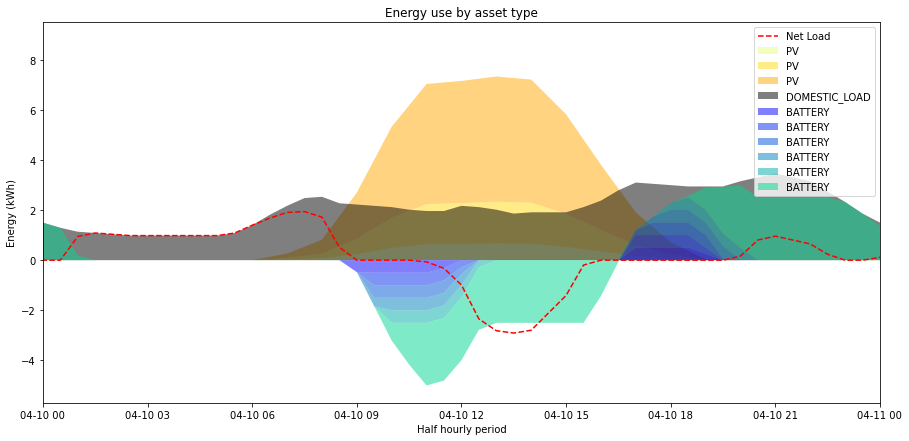

In [8]:
print('Operating cost: £ %.2f'%(opCost/100))

date_index = pd.date_range(start=datetime.datetime(2017,1,1), end=datetime.datetime(2017,12,31,23,59,59), freq='0.5H')

all_asset_types = [asset.asset_type for asset in all_assets]

# asset_type list [[PV],[DOMESTIC_LOAD], [BATTERY]]
assets_by_type = [[],[],[]]
asset_types = [[],[],[]]
asset_colours = [[],[],[]]
for asset in all_assets:
    if asset.asset_type == 'PV':
        assets_by_type[0].append(asset)
        asset_types[0].append('PV')
    if asset.asset_type == 'DOMESTIC_LOAD':
        assets_by_type[1].append(asset)
        asset_types[1].append('DOMESTIC_LOAD')
    if asset.asset_type in ['IDEAL BATTERY', 'PRACTICAL BATTERY']:
        assets_by_type[2].append(asset)
        asset_types[2].append('BATTERY')

pv_colourmap = cm.get_cmap("Wistia")
load_colourmap = cm.get_cmap('copper')
bat_colourmap = cm.get_cmap('winter')
asset_colours[0] = pv_colourmap(range(0,256,int(np.ceil(256/len(assets_by_type[0])))))
asset_colours[1] = load_colourmap(range(0,256,int(np.ceil(256/len(assets_by_type[1])))))
asset_colours[2] = bat_colourmap(range(0,256,int(np.ceil(256/len(assets_by_type[2])))))


# plot breakdown of asset contribution to net load
fig, ax1 = plt.subplots(figsize=(15,7))
for asset_group, colours, types in zip(assets_by_type, asset_colours, asset_types):
    asset_outputs = np.array([asset.output.flatten() for asset in asset_group])
    ax1.stackplot(date_index, asset_outputs, colors=colours, alpha=0.5, labels=types)

ax1.plot(date_index,net_load, '--r', label='Net Load')
ax1.set_ylabel("Energy (kWh)")
ax1.set_xlabel("Half hourly period")
ax1.set_title("Energy use by asset type")
ax1.set_xlim((datetime.datetime(2017,4,10), datetime.datetime(2017,4,11)))
ax1.legend()
plt.show()